<h1 align='center'><b>Введение в нейронные сети<b></h1>

<h2 align='center'>Урок 6. Сегментация</h2>

<h3 align='left'>Практическое задание:</h3>  
<ol>
<ol>
    <li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете.<br>
    Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>
</ol>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from IPython.display import clear_output

import matplotlib.pyplot as plt
import cv2
from pathlib import Path


### Исходное решение

Использовался датасет https://www.kaggle.com/carlolepelaars/camvid

In [ ]:
np.random.seed(42)

In [ ]:
class_dict = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/class_dict.csv')

path_train = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/train/'
path_train_labels = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/train_labels/'
path_test = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/test/'
path_test_labels = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/test_labels/'
path_val = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/val/'
path_val_labels = '/content/drive/MyDrive/Colab_Notebooks/22_введение_в_нейронные_сети/Lesson_6/input/CamVid/val_labels/'

In [ ]:
train_images_paths = list(Path(path_train).iterdir())

In [ ]:
single_image = tf.keras.preprocessing.image.load_img(train_images_paths[2]).size
single_image

(960, 720)

Загружаем картинки

Размеры делятся на 2 несколько раз, можно было оставить исходные. Но при преобразовании датасета заканчивается объем ОЗУ на коллабе, поэтому сожму картинки.

In [ ]:
train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [ ]:
image_size = (120, 180)

In [ ]:
%%time

train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
  train_images.append(tf.keras.preprocessing.image.load_img(i_img, target_size=image_size))
  train_masks.append(tf.keras.preprocessing.image.load_img(i_mask, target_size=image_size))

In [ ]:
%%time

test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
  test_images.append(tf.keras.preprocessing.image.load_img(i_img, target_size=image_size))
  test_masks.append(tf.keras.preprocessing.image.load_img(i_mask, target_size=image_size))

CPU times: user 8.77 s, sys: 490 ms, total: 9.26 s
Wall time: 5min 36s


In [ ]:
%%time

val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
  val_images.append(tf.keras.preprocessing.image.load_img(i_img, target_size=image_size))
  val_masks.append(tf.keras.preprocessing.image.load_img(i_mask, target_size=image_size))

CPU times: user 3.74 s, sys: 181 ms, total: 3.92 s
Wall time: 2min 20s


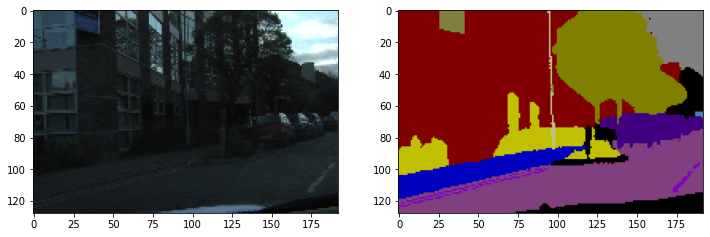

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(train_images[15].convert('RGBA'))
ax[1].imshow(train_masks[15].convert('RGBA'))

Создаём обучающую выборку

In [ ]:
X_train = []

for img in train_images:
  x = tf.keras.preprocessing.image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)
print(X_train.shape)

(369, 128, 192, 3)


In [ ]:
X_test = []

for img in test_images:
  x = tf.keras.preprocessing.image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

(232, 128, 192, 3)


In [ ]:
X_val = []

for img in val_images:
  x = tf.keras.preprocessing.image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(100, 128, 192, 3)


Посмотрим на разметку

In [ ]:
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


Делаем конвертер в one-hot_encoding для выходных примеров

In [ ]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b])

In [ ]:
def Color2index(y, arr_col=arr_col):

  y_ind = np.zeros((y.shape[0], y.shape[1]))
  y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where(
        (y[..., 0] == i_color[0])
        & (y[..., 1] == i_color[1])
        & (y[..., 2] == i_color[2])        
    )
    y_ind[ind_i[0], ind_i[1]] = i
    y_cat[ind_i[0], ind_i[1], i-1] = 1
    i += 1
  
  return y_cat, y_ind#, i-1

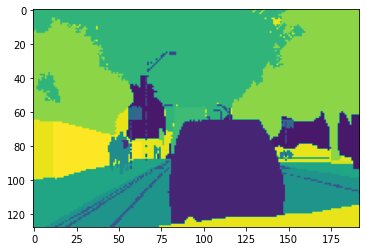

In [ ]:
cat_yi, ind_yi = Color2index(tf.keras.preprocessing.image.img_to_array(train_masks[3]))
plt.imshow(ind_yi)
plt.show()

In [ ]:
ind_yi

array([[22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       [22., 22., 22., ..., 27., 27., 27.],
       ...,
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.],
       [20., 20., 20., ..., 31., 31., 31.]])

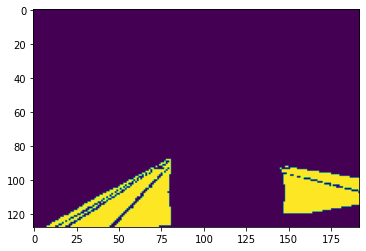

In [ ]:
plt.imshow(cat_yi[..., 17])
plt.show()

In [ ]:
cat_yi.shape

(128, 192, 32)

Сегментированную картинку в  One hot encoding (разметка на 32 класса)

In [ ]:
y_train = []

for mask in train_masks:
  y_cat, _ = Color2index(tf.keras.preprocessing.image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

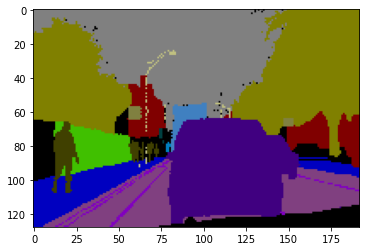

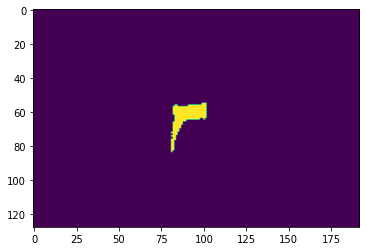

In [ ]:
n = 0 
plt.imshow(train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

In [ ]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(tf.keras.preprocessing.image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [ ]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(tf.keras.preprocessing.image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)

In [ ]:
print(f'{X_train.shape}, \n{y_train.shape}')

(369, 128, 192, 3), 
(369, 128, 192, 32)


In [ ]:
def unet_pre_train(num_classes=32, input_shape=(128, 192, 3)):
  pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

  for layer in pre_trained_model.layers[:-5]:
    layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.input
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)

    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    #UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    #UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    #UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

58889256/58889256 [==============================] - 3s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


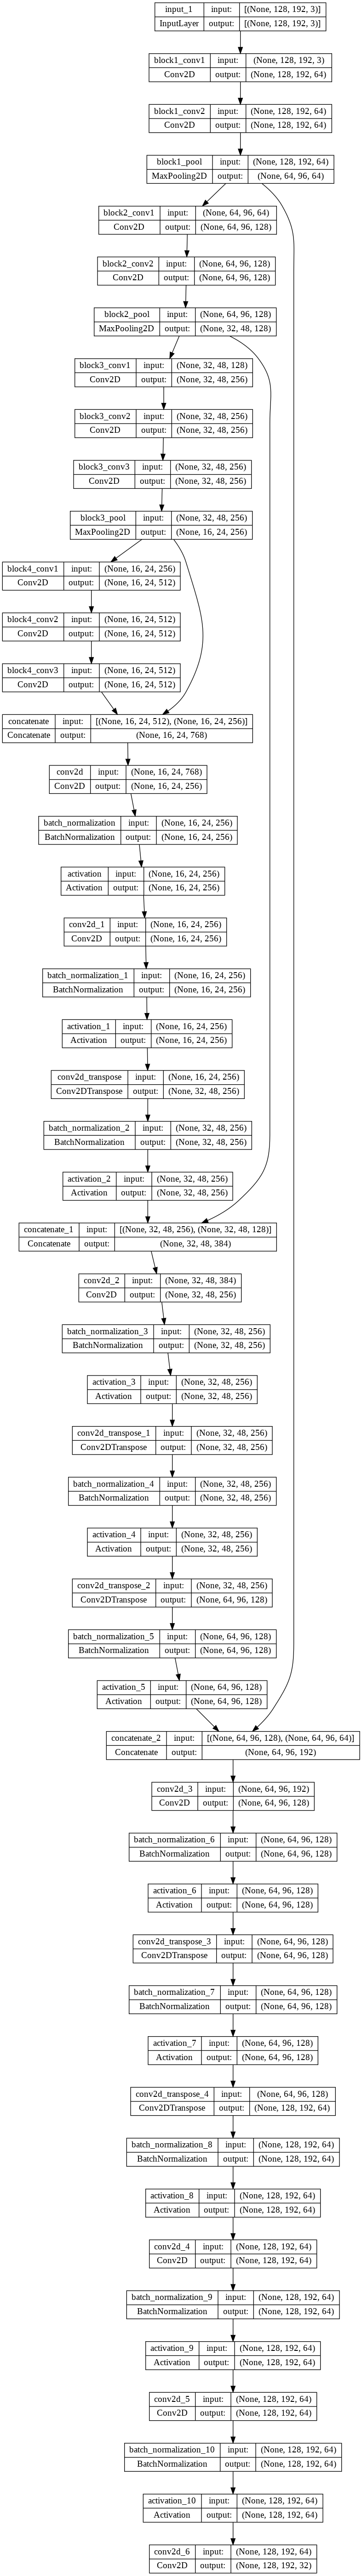

In [ ]:
model = unet_pre_train(32, (128, 192, 3))

plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))
  # return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred) + 1)

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 192, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 192, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
sample_image = X_test[1]
sample_mask = y_test[1]

In [ ]:
def show_predictions(model):
  pred_mask = model.predict(sample_image[None])[..., 16]
  print(pred_mask.shape)

  fig, ax = plt.subplots(1, 3, figsize=(15, 8))

  ax[0].imshow(sample_image / 255.0)
  ax[1].imshow(sample_mask[..., 16])
  ax[2].imshow(np.squeeze(pred_mask, axis=0))
  plt.show()

class DisplayCallback(keras.callbacks.Callback):
  def __init__(self, patience=1):
    super().__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    self.wait += 1
    if self.wait >= self.patience:
      clear_output(wait=True)
      show_predictions(self.model)
      print(f'\nSample Prediction after epoch {epoch+1}')
      self.wait = 0

1/1 [==============================] - 10s 10s/step
(1, 128, 192)


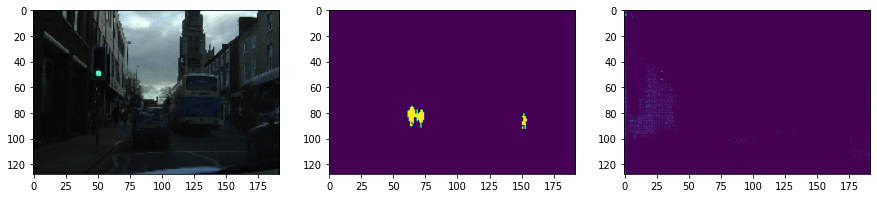

In [ ]:
show_predictions(model)

1/1 [==============================] - 0s 29ms/step


(1, 128, 192)


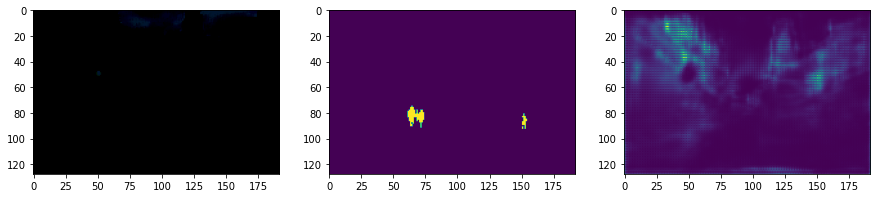


Sample Prediction after epoch 20
37/37 [==============================] - 10s 273ms/step - loss: 0.3562 - dice_coef: 0.8391 - val_loss: 0.7098 - val_dice_coef: 0.7728


In [ ]:
from keras import callbacks
history = model.fit(preprocess_input(X_train), y_train,
                    epochs=20,
                    batch_size=10,
                    validation_data=(preprocess_input(X_test), y_test),
                    callbacks=[DisplayCallback(patience=5)])

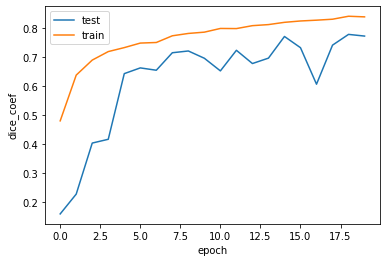

In [ ]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()


Тестируем на валидационных данных

In [ ]:
pred = model.predict(X_val)
print(pred.shape)

4/4 [==============================] - 8s 725ms/step
(100, 128, 192, 32)


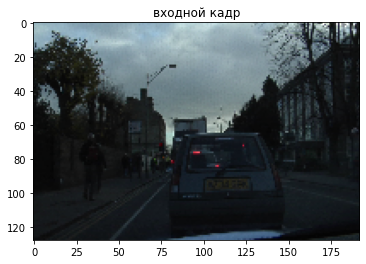

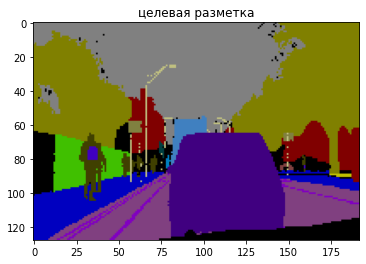

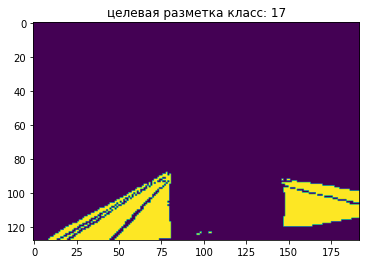

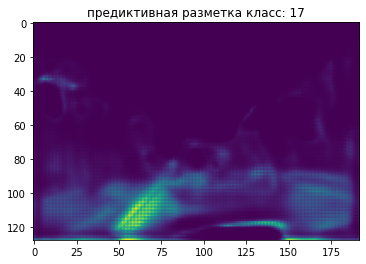

In [ ]:
n = 3
class_ = 17
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA')) 
plt.title('целевая разметка')
plt.show()
img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

**Вывод:**  
Я решил задачу сегментации изображения на наборе данных CamVid (Cambridge-Driving Labeled Video Database) для 32 классов с помощью нейронной сети u-net, взяв уже обученный энкодер из  VGG16.